## Create classification datasets

In [1]:
import pandas as pd

In [41]:
df1 = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Artwork.parquet.gzip')
df1['url'][1]

'http://wikigallery.org/wiki/painting_9698/Vincent-Van-Gogh/Starry-Night'

In [2]:
# Real paintings
df1 = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Artwork.parquet.gzip')
df1.drop(columns=['name', 'url', 'artist', 'rating', 'summary', 'year', 'medium', 'location'], inplace=True)
df1['AI_generated'] = False
df1.head()

,id,image_url,AI_generated
0,0,https://kuleuven-datathon-2023.s3.eu-central-1...,False
1,1,https://kuleuven-datathon-2023.s3.eu-central-1...,False
2,2,https://kuleuven-datathon-2023.s3.eu-central-1...,False
3,3,https://kuleuven-datathon-2023.s3.eu-central-1...,False
4,4,https://kuleuven-datathon-2023.s3.eu-central-1...,False


In [20]:
# AI generated paintings
df2 = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Generated.parquet.gzip')
df2 = df2.rename(columns={'url': 'image_url'})
df2['AI_generated'] = True
df2.head()

,source_artwork,image_url,AI_generated
0,3148,https://kuleuven-datathon-2023.s3.eu-central-1...,True
1,1480,https://kuleuven-datathon-2023.s3.eu-central-1...,True
2,182,https://kuleuven-datathon-2023.s3.eu-central-1...,True
3,2493,https://kuleuven-datathon-2023.s3.eu-central-1...,True
4,2497,https://kuleuven-datathon-2023.s3.eu-central-1...,True


## Image inspection

Notes:

**Real paintings**
- different sizes
- wikigallery banner (can be on top or bottom)
- wikigallery logo (e.g., df1[40])

**AI generated**
- censored (black) images (e.g., df2[202])

In [10]:
import io
import matplotlib.pyplot as plt
import requests
from PIL import Image

def display_artwork(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

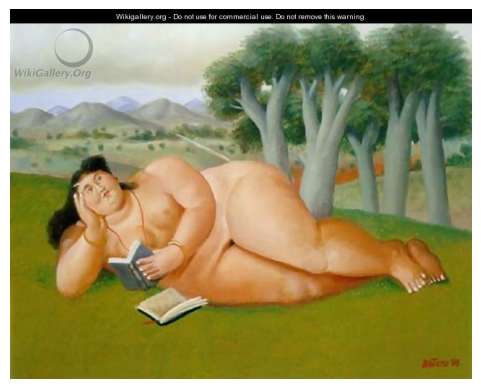

In [44]:
display_artwork(df1.image_url.values[85])

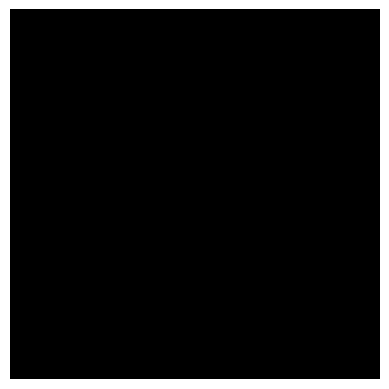

In [34]:
display_artwork(df2.image_url.values[202])

## Image preprocessing - real paintings (df1)
    (1) Remove black Wikigallery border

Before:


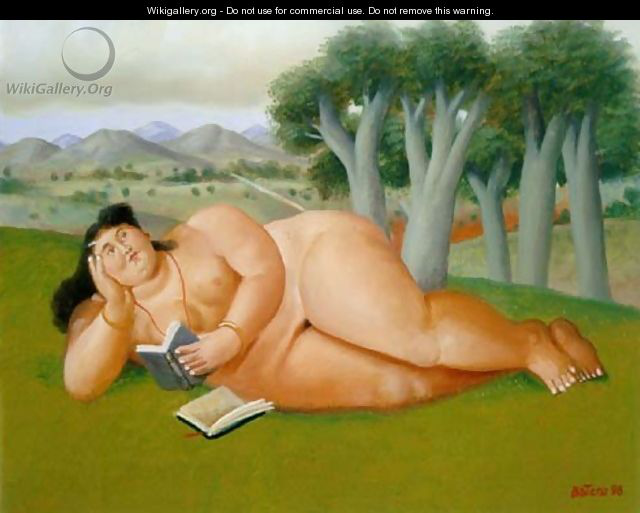

After:


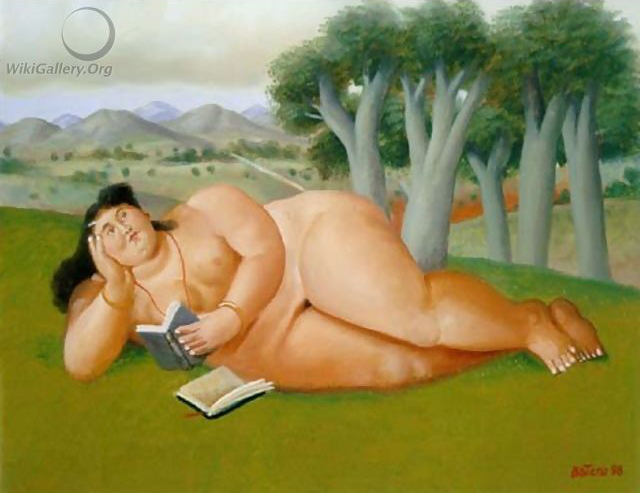

In [141]:
'''Remove black banners'''

# Steps:
# 1 - create copy of image
# 2 - make all white/gray pixels of copy black (white_to_black)
# 3 - identify black banners in copy (trim)
# 4 - remove black banners from original image

# Loading data
url = df1.image_url.values[85]
response = requests.get(url)
image = Image.open(io.BytesIO(response.content))

# Trim function
def trim(image, image_copy):
    background = Image.new(image_copy.mode, image_copy.size, (0,0,0))  # Create black square with same size as original painting
    diff = ImageChops.difference(image_copy, background)  # Find difference between black square and painting
    diff = ImageChops.add(diff, diff, 2.0, -100)  # 
    bbox = diff.getbbox()
    if bbox:
        return image.crop(bbox)
    
# Make white letters in banner black
def white_to_black(image):
    width, height = image.size
    # Loop through every pixel and change white pixels to black
    for x in range(width):
        for y in range(height):
            # Get pixel value
            pixel = image.getpixel((x, y))
            # Check if pixel is white/gray (includes white text)
            if pixel == (255, 255, 255) or pixel == 255 or (pixel[0] == pixel[1] == pixel[2]):
                # Set pixel to black
                image.putpixel((x, y), (0, 0, 0))

image_copy = image.copy()
white_to_black(image_copy)
image_new = trim(image, image_copy)
print('Before:')
display(image)
print('After:')
display(image_new)

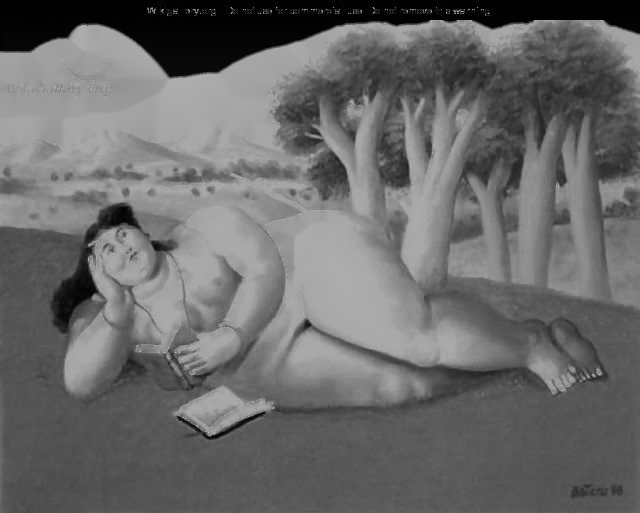

In [74]:
# Attempt at watermark removal
import cv2
url = df1.image_url.values[85]
response = requests.get(url)
image = Image.open(io.BytesIO(response.content))

image2 = np.array(image)
gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)
result = cv2.inpaint(gray, thresh, 3, cv2.INPAINT_TELEA)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
result_pil = Image.fromarray(result)
result_pil

(640, 513)